<a href="https://colab.research.google.com/github/mahadrafan/Analisis-Faktor-Dominan-dan-Pemodelan-Spasial-untuk-Prediksi-Kejernihan-Air-Danau/blob/main/Analisis_Faktor_Dominan_dan_pemodelan_spasial_untuk_prediksi_kejernihan_air_danau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) Versions, seeds, paths, warnings

In [ ]:
import sys, os, warnings, numpy as np, pandas as pd, matplotlib
np.random.seed(42)
RANDOM_STATE = 42
DATA_PATH = "/content/secchi_regions - secchi_regions_10yr.csv"

warnings.filterwarnings("ignore", message=r"X does not have valid feature names, but.*")

print(sys.version)
try:
    import sklearn, lightgbm
    print("sklearn", sklearn.__version__)
    print("lightgbm", getattr(lightgbm, "__version__", "NA"))
except Exception as e:
    print("Version check note:", e)


3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
sklearn 1.6.1
lightgbm 4.6.0


# 1) Imports

In [ ]:
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from scipy.stats import spearmanr

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False
    from sklearn.ensemble import RandomForestRegressor


# 2) parsing

In [ ]:
import re

def _parse_one_num(txt: str):
    if txt is None:
        return np.nan
    s = str(txt).strip()
    if s == "" or s.lower() in {"nan", "na", "none"}:
        return np.nan
    s = s.replace("\u00A0", " ").replace(" ", "")
    has_dot = "." in s
    has_com = "," in s

    if not has_dot and not has_com:
        try: return float(s)
        except: return np.nan

    if has_dot and has_com:
        last = max(s.rfind("."), s.rfind(","))
        dec = s[last]
        if dec == ",":
            s = s.replace(".", "").replace(",", ".")
        else:
            s = s.replace(",", "")
        try: return float(s)
        except: return np.nan

    if has_com:
        m = re.match(r"^\d{1,3}(?:,\d{3})+$", s)
        if m:
            s = s.replace(",", "")
            try: return float(s)
            except: return np.nan
        s = s.replace(",", ".")
        try: return float(s)
        except: return np.nan

    if has_dot:
        m = re.match(r"^\d{1,3}(?:\.\d{3})+$", s)
        if m:
            s = s.replace(".", "")
            try: return float(s)
            except: return np.nan
        try: return float(s)
        except: return np.nan

    return np.nan

def parse_numeric_general(series: pd.Series) -> pd.Series:
    return series.apply(_parse_one_num).astype(float)

def _auto_rescale(series: pd.Series, upper_ok: float, name: str):
    s = pd.to_numeric(series, errors="coerce")
    if s.notna().sum() < 50:
        return s, 1.0
    q95 = s.quantile(0.95)
    if pd.isna(q95): return s, 1.0

    for d in [1, 10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]:
        if (q95 / d) <= upper_ok:
            if d != 1:
                print(f"[Auto-rescale] {name}: ÷ {d:g} (q95 {q95:.3g} → {(q95/d):.3g}, upper_ok={upper_ok})")
            return s / d, d
    print(f"[Auto-rescale] {name}: no divisor meets upper_ok={upper_ok}; keeping as-is.")
    return s, 1.0


# 3) Load & Fix Data

- parse numeric (clean & standardize)
- auto-rescale feature skala besar
- normalisasi koordinate
- remove mean_secchi <= 0 & cap 30m


In [ ]:
CAT_COLS = ["state_name","lakeconnectivity","glacial"]
EXCLUDE = {
    "mean_secchi","median_secchi","sd_secchi","covar_secchi","nobs_secchi",
    "recordID","lagoslakeid","nhdid","hu12_zoneid","hu4_zoneid","hu8_zoneid","edu_zoneid","iws_zone_id"
}

def load_and_fix(path=DATA_PATH):
    df = pd.read_csv(path, dtype=str, low_memory=False)

    num_direct = ["mean_secchi","median_secchi","maxdepth","meandepth","nobs_secchi"]
    num_mixed  = ["sd_secchi","covar_secchi","nhd_lat","nhd_long",
                  "lake_area_ha","lake_perim_meters","iws_area_ha",
                  "pcturbancombined_hu12","pctagcombined_hu12",
                  "pctpasturehay_hu12","pctrowcrop_hu12"]

    for c in num_direct:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in num_mixed:
        if c in df: df[c] = parse_numeric_general(df[c])

    if "nhd_lat" in df:
        lat = pd.to_numeric(df["nhd_lat"], errors="coerce")
        df["nhd_lat"] = lat / 1e6 if lat.abs().max(skipna=True) > 90 else lat
    if "nhd_long" in df:
        lon = pd.to_numeric(df["nhd_long"], errors="coerce")
        df["nhd_long"] = lon / 1e6 if lon.abs().max(skipna=True) > 180 else lon

    df = df[pd.to_numeric(df["mean_secchi"], errors="coerce") > 0].copy()
    df["mean_secchi"] = pd.to_numeric(df["mean_secchi"], errors="coerce").clip(0.1, 30.0)

    for c in ["pcturbancombined_hu12","pctagcombined_hu12","pctpasturehay_hu12","pctrowcrop_hu12"]:
        if c in df:
            s = pd.to_numeric(df[c], errors="coerce")
            if s.max(skipna=True) > 1000: s = s / 1e4
            df[c] = s.clip(0, 100)

    if "lake_area_ha" in df:
        df["lake_area_ha"], _ = _auto_rescale(df["lake_area_ha"], upper_ok=1e5, name="lake_area_ha")
    if "iws_area_ha" in df:
        df["iws_area_ha"], _ = _auto_rescale(df["iws_area_ha"], upper_ok=1e6, name="iws_area_ha")
    if "lake_perim_meters" in df:
        df["lake_perim_meters"], _ = _auto_rescale(df["lake_perim_meters"], upper_ok=2e5, name="lake_perim_meters")

    if "nhd_lat" in df:
        s = pd.to_numeric(df["nhd_lat"], errors="coerce")
        bad = s.notna() & ~s.between(-90, 90)
        if bad.any(): df = df.loc[~bad].copy()
    if "nhd_long" in df:
        s = pd.to_numeric(df["nhd_long"], errors="coerce")
        bad = s.notna() & ~s.between(-180, 180)
        if bad.any(): df = df.loc[~bad].copy()

    for c in ["lake_area_ha","lake_perim_meters","iws_area_ha"]:
        if c in df:
            s = pd.to_numeric(df[c], errors="coerce")
            if s.notna().sum() > 50:
                lo, hi = s.quantile([0.001, 0.999])
                df[c] = s.clip(lo, hi)
            else:
                df[c] = s

    for c in CAT_COLS:
        if c in df: df[c] = df[c].astype("object")

    return df.reset_index(drop=True)

df = load_and_fix()
print(f"[Loaded] shape={df.shape} | # at cap=30m: {(df['mean_secchi']==30).sum()}")


[Auto-rescale] lake_area_ha: ÷ 100000 (q95 8.8e+09 → 8.8e+04, upper_ok=100000.0)
[Auto-rescale] iws_area_ha: ÷ 10000 (q95 8.74e+09 → 8.74e+05, upper_ok=1000000.0)
[Auto-rescale] lake_perim_meters: ÷ 100000 (q95 8.85e+09 → 8.85e+04, upper_ok=200000.0)
[Loaded] shape=(4984, 29) | # at cap=30m: 763


# 4) Sanity checks

Check ke-normalan data

- summary lake area

**Objective**
- Jika data tidak "normal", fungsi akan throw error


        lake_area_ha  min=65.1 | med=2.96e+04 | p95=8.8e+04 | max=9.97e+04
         iws_area_ha  min=166 | med=2.75e+05 | p95=8.74e+05 | max=9.98e+05
   lake_perim_meters  min=108 | med=2.98e+04 | p95=8.85e+04 | max=9.98e+04


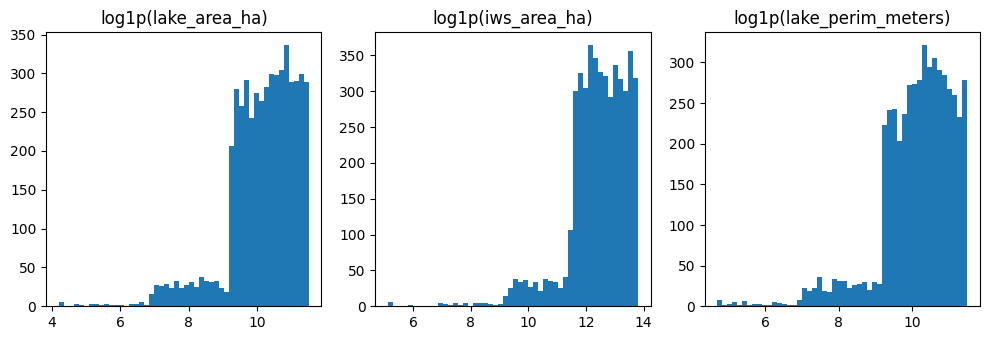

In [ ]:
def _brief_size_report(df):
    for name, upper_ok in [("lake_area_ha", 1e5), ("iws_area_ha", 1e6), ("lake_perim_meters", 2e5)]:
        if name in df:
            s = pd.to_numeric(df[name], errors="coerce")
            print(f"{name:>20s}  min={s.min():.3g} | med={s.median():.3g} | p95={s.quantile(0.95):.3g} | max={s.max():.3g}")
            if s.dropna().median() > upper_ok:
                raise ValueError(f"[Scale check] {name} median unusually large → parsing/rescale still off.")

_brief_size_report(df)

plt.figure(figsize=(10,3.5))
for i,name in enumerate(["lake_area_ha","iws_area_ha","lake_perim_meters"],1):
    if name in df:
        vals = pd.to_numeric(df[name], errors="coerce").dropna()
        if len(vals):
            plt.subplot(1,3,i); plt.hist(np.log1p(vals), bins=50); plt.title(f"log1p({name})")
plt.tight_layout(); plt.show()


# 5) EDA — essentials, univariate, bivariate, spatial, dashboard + thesis

Shape: (4984, 29)


,recordID,hu12_zoneid,lagoslakeid,mean_secchi,median_secchi,sd_secchi,covar_secchi,nobs_secchi,nhdid,nhd_lat,...,hu8_zoneid,edu_zoneid,state_name,iws_area_ha,lakeconnectivity,glacial,pcturbancombined_hu12,pctagcombined_hu12,pctpasturehay_hu12,pctrowcrop_hu12
0,1,HU12_10001,1104,30.00,0.610,108962914.0,175393021.0,4,120018426,43.903086,...,HU8_365,EDU_41,Minnesota,491491.2251,DR_Stream,Glaciated,0.000709,84.929900,0.000000,84.929900
1,2,HU12_10010,3149,30.00,0.530,344131758.0,516714351.0,10,120018420,44.138477,...,HU8_365,EDU_41,Minnesota,915077.7551,DR_Stream,Glaciated,0.000479,83.184600,0.178900,83.005700
2,4,HU12_10054,39040,0.20,0.200,NaN,NaN,1,159101704,43.662307,...,HU8_353,EDU_23,Minnesota,455582.9476,DR_Stream,Glaciated,18.998400,45.714200,0.246900,43.245200
3,5,HU12_10056,3523,0.90,0.900,141421356.0,15713484.0,2,adfdf197-9f62-4650-8866-676709b89aee,44.495383,...,HU8_330,EDU_13,Wisconsin,314416.0088,DR_LakeStream,Not_Glaciated,0.000580,30.865700,0.000494,25.922800
4,6,HU12_10058,2256,30.00,9.906,982123115.0,724087348.0,3,42798634,44.262702,...,HU8_375,EDU_13,Wisconsin,446540.2171,DR_Stream,Not_Glaciated,0.545800,16.476400,0.000545,0.001103
5,7,HU12_10062,4728,30.00,54.864,NaN,NaN,1,120018194,43.917547,...,HU8_376,EDU_13,Wisconsin,175552.0167,DR_LakeStream,Not_Glaciated,17.892200,13.093400,0.000534,0.000775
6,8,HU12_10063,294,30.00,42.672,NaN,NaN,1,41240771,43.851611,...,HU8_376,EDU_13,Wisconsin,846489.0739,Isolated,Not_Glaciated,35.220900,0.000316,0.886700,0.000227
7,10,HU12_10070,766,2.29,2.290,NaN,NaN,1,37649149,44.666613,...,HU8_330,EDU_13,Minnesota,182420.0219,DR_Stream,Glaciated,3.741600,42.585900,15.836900,2.674900


,recordID,hu12_zoneid,lagoslakeid,mean_secchi,median_secchi,sd_secchi,covar_secchi,nobs_secchi,nhdid,nhd_lat,...,hu8_zoneid,edu_zoneid,state_name,iws_area_ha,lakeconnectivity,glacial,pcturbancombined_hu12,pctagcombined_hu12,pctpasturehay_hu12,pctrowcrop_hu12
dtype,object,object,object,float64,float64,float64,float64,int64,object,float64,...,object,object,object,float64,object,object,float64,float64,float64,float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   recordID               4984 non-null   object 
 1   hu12_zoneid            4984 non-null   object 
 2   lagoslakeid            4984 non-null   object 
 3   mean_secchi            4984 non-null   float64
 4   median_secchi          4983 non-null   float64
 5   sd_secchi              2767 non-null   float64
 6   covar_secchi           2767 non-null   float64
 7   nobs_secchi            4984 non-null   int64  
 8   nhdid                  4984 non-null   object 
 9   nhd_lat                4984 non-null   float64
 10  nhd_long               56 non-null     float64
 11  lake_area_ha           4984 non-null   float64
 12  lake_perim_meters      4984 non-null   float64
 13  lagosname1             4984 non-null   object 
 14  meandepth              1155 non-null   float64
 15  maxd

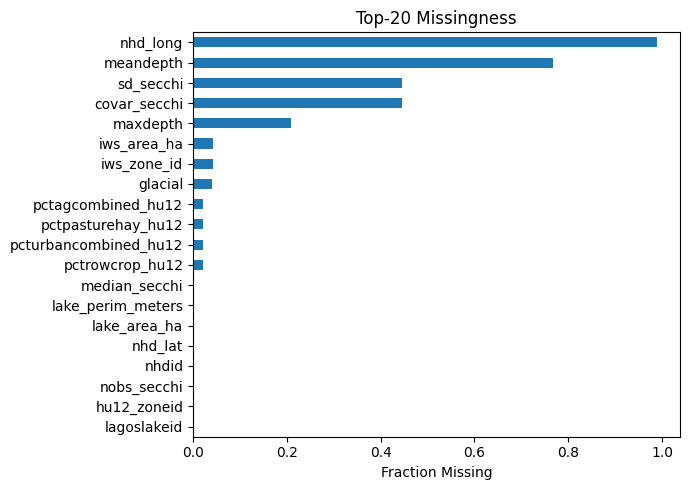

In [ ]:
print("Shape:", df.shape)
display(df.head(8))
display(df.dtypes.to_frame("dtype").T)
df.info()

miss = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(7,5))
miss.head(20).iloc[::-1].plot(kind="barh")
plt.xlabel("Fraction Missing"); plt.title("Top-20 Missingness"); plt.tight_layout(); plt.show()


**Insight**

- Kolom sd_secchi / covar_secchi sering paling banyak missing → remove feature
- Variabel kategori (state_name, lakeconnectivity, glacial)

## histogram

- histogram target & log(target)
- bar top 12 misisngness
- scatter LOWESS

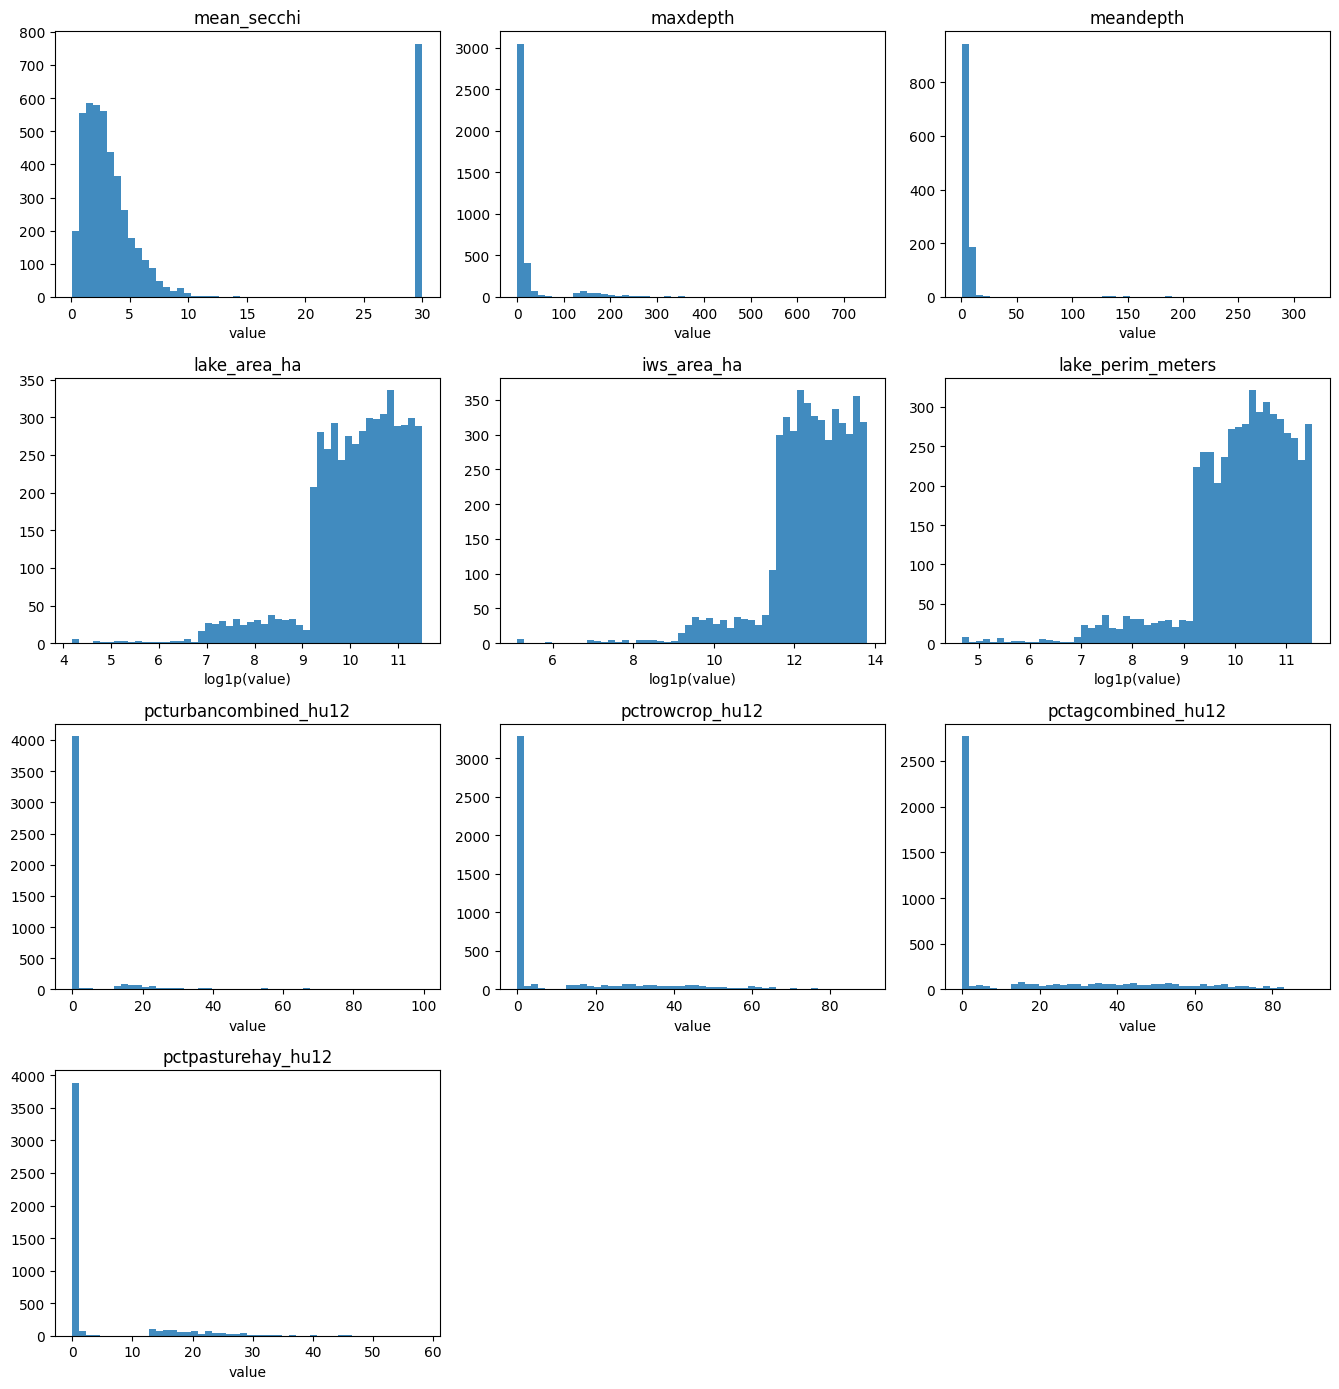

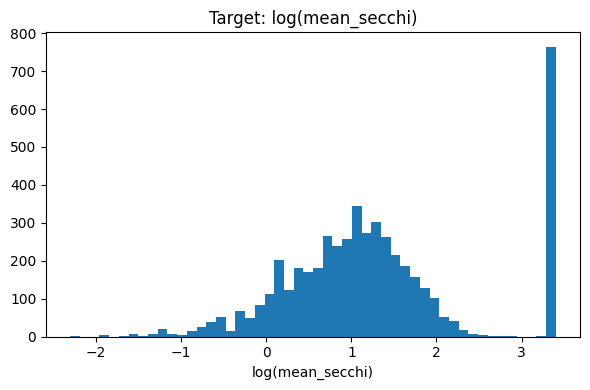

In [ ]:
def _hist(ax, s, title, bins=50, logx=False):
    x = pd.to_numeric(pd.Series(s), errors="coerce").dropna().values
    if not len(x): ax.set_axis_off(); ax.set_title(f"{title}\n(no data)"); return
    if logx:
        x = np.log1p(np.clip(x, 0, None)); ax.set_xlabel("log1p(value)")
    else:
        ax.set_xlabel("value")
    ax.hist(x, bins=bins, alpha=0.85); ax.set_title(title)

targets = ["mean_secchi"]
drivers = ["maxdepth","meandepth","lake_area_ha","iws_area_ha","lake_perim_meters",
           "pcturbancombined_hu12","pctrowcrop_hu12","pctagcombined_hu12","pctpasturehay_hu12"]
plots = [c for c in targets+drivers if c in df.columns]

n = len(plots); cols = 3; rows = int(np.ceil(n/cols))
plt.figure(figsize=(cols*4.5, rows*3.5))
for i,c in enumerate(plots,1):
    ax = plt.subplot(rows, cols, i)
    _hist(ax, df[c], f"{c}", bins=50, logx=(c in ["lake_area_ha","iws_area_ha","lake_perim_meters"]))
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(np.log(pd.to_numeric(df["mean_secchi"], errors="coerce").clip(1e-6,None)), bins=50)
plt.xlabel("log(mean_secchi)"); plt.title("Target: log(mean_secchi)"); plt.tight_layout(); plt.show()


**Insight**

- Target very right-skewed -> transformasi log cocok
- mean/maxdepth positif terhadap clarity
- urban/row-crop negatif terhadap clarity
- Gradient spasial: latitut tinggi cenderung lebih clear

"semakin dalam -> semakin jernih; daerah dengan urban/row-crop tinggi -> lebih keruh; ada pola spasial"

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
y = pd.to_numeric(df["mean_secchi"], errors="coerce")

rows = []
for c in num_cols:
    if c == "mean_secchi": continue
    x = pd.to_numeric(df[c], errors="coerce")
    m = x.notna() & y.notna()
    if m.sum() >= 50:
        rho, p = spearmanr(x[m], y[m])
        rows.append((c, rho, p, int(m.sum())))
spearman_df = pd.DataFrame(rows, columns=["feature","spearman_rho","pvalue","n"]).sort_values("spearman_rho", ascending=False)
display(spearman_df.head(12))
display(spearman_df.tail(12))


,feature,spearman_rho,pvalue,n
0,median_secchi,0.783945,0.000000e+00,4983
3,nobs_secchi,0.424920,9.996932e-218,4984
9,maxdepth,0.299264,2.255903e-82,3942
8,meandepth,0.205291,1.861596e-12,1155
1,sd_secchi,0.121348,1.513578e-10,2767
4,nhd_lat,0.106467,4.852752e-14,4984
7,lake_perim_meters,0.010109,4.755445e-01,4984
6,lake_area_ha,0.004222,7.656853e-01,4984
10,iws_area_ha,0.002376,8.696657e-01,4772
5,nhd_long,-0.009607,9.439750e-01,56


,feature,spearman_rho,pvalue,n
8,meandepth,0.205291,1.861596e-12,1155
1,sd_secchi,0.121348,1.513578e-10,2767
4,nhd_lat,0.106467,4.852752e-14,4984
7,lake_perim_meters,0.010109,4.755445e-01,4984
6,lake_area_ha,0.004222,7.656853e-01,4984
10,iws_area_ha,0.002376,8.696657e-01,4772
5,nhd_long,-0.009607,9.439750e-01,56
13,pctpasturehay_hu12,-0.043012,2.655655e-03,4879
2,covar_secchi,-0.052897,5.382745e-03,2767
14,pctrowcrop_hu12,-0.093608,5.707070e-11,4879


**Insight**

- semakin tinggi kedalaman -> semakin jernih; tekanan antropogenik tinggi -> keruh.
- Fitur terkait Secchi (median/sd/covar/nobs) di remove karna p tinggi

/tmp/ipython-input-385702108.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, sub in df.assign(secchi_q=q).groupby("secchi_q"):


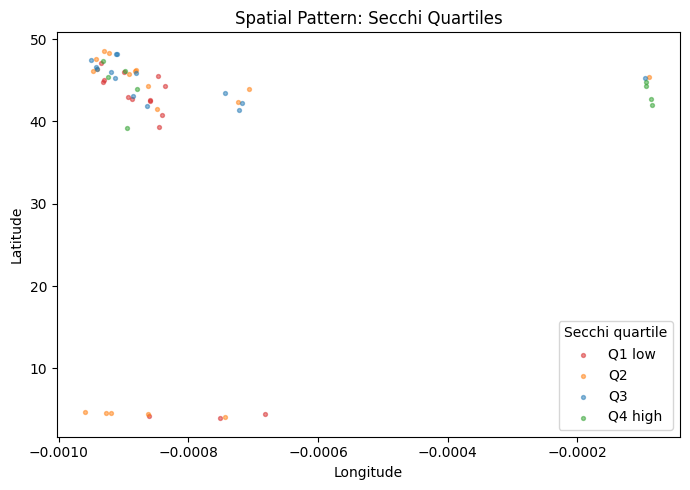

In [ ]:
if {"nhd_lat","nhd_long"}.issubset(df.columns):
    q = pd.qcut(pd.to_numeric(df["mean_secchi"], errors="coerce"), q=4, labels=["Q1 low","Q2","Q3","Q4 high"])
    plt.figure(figsize=(7,5))
    colors = {"Q1 low":"tab:red","Q2":"tab:orange","Q3":"tab:blue","Q4 high":"tab:green"}
    for label, sub in df.assign(secchi_q=q).groupby("secchi_q"):
        plt.scatter(pd.to_numeric(sub["nhd_long"], errors="coerce"),
                    pd.to_numeric(sub["nhd_lat"], errors="coerce"),
                    s=8, alpha=0.5, c=colors.get(str(label), "gray"), label=str(label))
    plt.legend(title="Secchi quartile", frameon=True)
    plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.title("Spatial Pattern: Secchi Quartiles")
    plt.tight_layout(); plt.show()


## Dashboard

/tmp/ipython-input-1713788458.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for lab, sub in df.assign(secchi_q=q).groupby("secchi_q"):


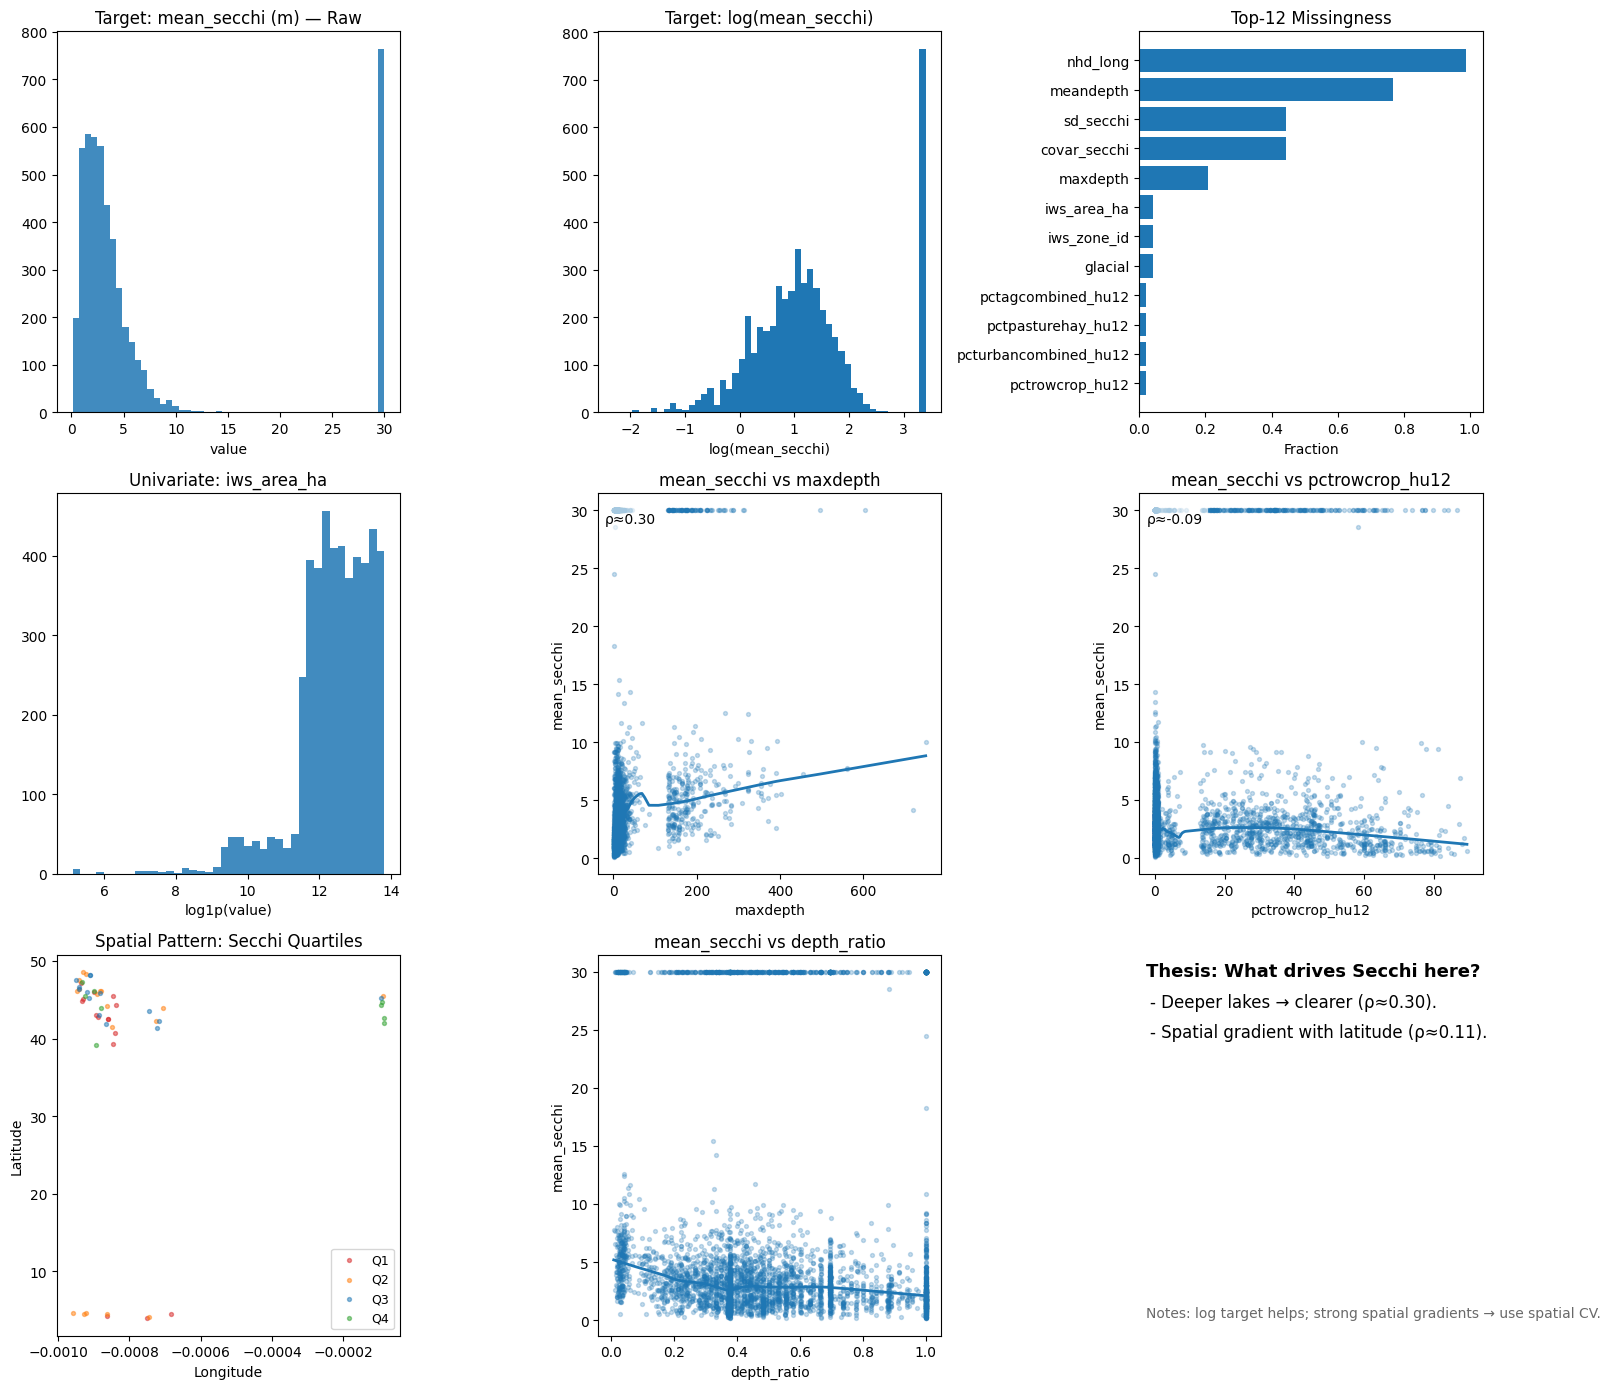

EDA dashboard saved → eda_dashboard.png


In [ ]:
def eda_dashboard(df, save_path="eda_dashboard.png"):
    from statsmodels.nonparametric.smoothers_lowess import lowess

    def hist(ax, s, title, bins=40, logx=False):
        x = pd.to_numeric(pd.Series(s), errors="coerce").dropna().values
        if not len(x): ax.set_axis_off(); ax.set_title(f"{title}\n(no data)"); return
        if logx: x = np.log1p(np.clip(x, 0, None)); ax.set_xlabel("log1p(value)")
        else: ax.set_xlabel("value")
        ax.hist(x, bins=bins, alpha=0.85); ax.set_title(title)

    def scatter_lowess(ax, x, y, xlabel, ylabel, sample=4000, logx=False):
        x = pd.to_numeric(pd.Series(x), errors="coerce"); y = pd.to_numeric(pd.Series(y), errors="coerce")
        m = x.notna() & y.notna()
        x, y = x[m], y[m]
        if not len(x): ax.set_axis_off(); ax.set_title(f"{ylabel} vs {xlabel}\n(no data)"); return
        if len(x) > sample:
            idx = np.random.default_rng(42).choice(len(x), size=sample, replace=False)
            x, y = x.iloc[idx], y.iloc[idx]
        xx = np.log1p(np.clip(x,0,None)) if logx else x
        ax.scatter(xx, y, s=8, alpha=0.25)
        try:
            fit = lowess(y.values, xx.values, frac=0.3, return_sorted=True)
            ax.plot(fit[:,0], fit[:,1], linewidth=2)
        except: pass
        ax.set_xlabel(f"log1p({xlabel})" if logx else xlabel); ax.set_ylabel(ylabel)
        ax.set_title(f"{ylabel} vs {xlabel}")

    target = pd.to_numeric(df["mean_secchi"], errors="coerce")
    Xfe = None
    def get_fe():
        nonlocal Xfe
        if Xfe is None: Xfe = engineer_features(df.copy())
        return Xfe

    miss = df.isna().mean().sort_values(ascending=False).head(12)
    have_geo = {"nhd_lat","nhd_long"}.issubset(df.columns)
    depth_col = "maxdepth" if "maxdepth" in df.columns else None
    size_col  = "iws_area_ha" if "iws_area_ha" in df.columns else ("lake_area_ha" if "lake_area_ha" in df.columns else None)
    ag_col    = "pctrowcrop_hu12" if "pctrowcrop_hu12" in df.columns else ("pcturbancombined_hu12" if "pcturbancombined_hu12" in df.columns else None)

    def rho(col):
        if col is None or col not in df: return np.nan
        a = pd.to_numeric(df[col], errors="coerce"); b = target
        m = a.notna() & b.notna()
        return np.nan if m.sum()<50 else spearmanr(a[m], b[m])[0]

    rho_depth, rho_size, rho_ag = rho(depth_col), rho(size_col), rho(ag_col)
    rho_lat = rho("nhd_lat") if "nhd_lat" in df else np.nan

    thesis = []
    if rho_depth==rho_depth and rho_depth>0.12: thesis.append(f"Deeper lakes → clearer (ρ≈{rho_depth:.2f}).")
    if rho_size==rho_size and rho_size>0.10:   thesis.append(f"Larger/watershed scale supports clarity (ρ≈{rho_size:.2f}).")
    if rho_ag==rho_ag and rho_ag<-0.10:        thesis.append(f"Agriculture/urban pressure reduces clarity (ρ≈{rho_ag:.2f}).")
    if rho_lat==rho_lat and abs(rho_lat)>0.10: thesis.append(f"Spatial gradient with latitude (ρ≈{rho_lat:.2f}).")
    if "depth_ratio" in (get_fe().columns if have_geo or True else []):
        xr = pd.to_numeric(get_fe()["depth_ratio"], errors="coerce"); m = xr.notna() & target.notna()
        if m.sum()>50:
            r = spearmanr(xr[m], target[m])[0]
            if r>0.10: thesis.append(f"Depth ratio aligns with clarity (ρ≈{r:.2f}).")
    if not thesis: thesis=["Signals are weak; expect nonlinear & spatial effects."]

    fig, axes = plt.subplots(3, 3, figsize=(16, 14))
    (ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axes

    hist(ax1, target, "Target: mean_secchi (m) — Raw", bins=50)
    ax2.hist(np.log(np.clip(target,1e-6,None)), bins=50); ax2.set_xlabel("log(mean_secchi)"); ax2.set_title("Target: log(mean_secchi)")
    ax3.barh(miss.index[::-1], miss.values[::-1]); ax3.set_title("Top-12 Missingness"); ax3.set_xlabel("Fraction")

    if size_col: hist(ax4, df[size_col], f"Univariate: {size_col}", bins=40, logx=(size_col in ["iws_area_ha","lake_area_ha","lake_perim_meters"]))
    else: ax4.axis("off"); ax4.text(0.05,0.5,"No size variable", fontsize=12)

    if depth_col:
        scatter_lowess(ax5, df[depth_col], target, depth_col, "mean_secchi", logx=False)
        if rho_depth==rho_depth: ax5.text(0.02,0.92,f"ρ≈{rho_depth:.2f}", transform=ax5.transAxes, fontsize=10, bbox=dict(facecolor="white",alpha=.6, edgecolor="none"))
    else: ax5.axis("off")

    if ag_col:
        scatter_lowess(ax6, df[ag_col], target, ag_col, "mean_secchi", logx=False)
        if rho_ag==rho_ag: ax6.text(0.02,0.92,f"ρ≈{rho_ag:.2f}", transform=ax6.transAxes, fontsize=10, bbox=dict(facecolor="white",alpha=.6, edgecolor="none"))
    else: ax6.axis("off")

    if have_geo:
        q = pd.qcut(target, q=4, labels=["Q1","Q2","Q3","Q4"])
        colors={"Q1":"tab:red","Q2":"tab:orange","Q3":"tab:blue","Q4":"tab:green"}
        for lab, sub in df.assign(secchi_q=q).groupby("secchi_q"):
            ax7.scatter(pd.to_numeric(sub["nhd_long"], errors="coerce"),
                        pd.to_numeric(sub["nhd_lat"], errors="coerce"),
                        s=8, alpha=0.5, c=colors.get(str(lab),"gray"), label=str(lab))
        ax7.set_xlabel("Longitude"); ax7.set_ylabel("Latitude"); ax7.set_title("Spatial Pattern: Secchi Quartiles"); ax7.legend(frameon=True, fontsize=9)
    else: ax7.axis("off")

    Xfe = get_fe()
    if "depth_ratio" in Xfe.columns:
        scatter_lowess(ax8, Xfe["depth_ratio"], target, "depth_ratio", "mean_secchi")
    elif "ag_intensity" in Xfe.columns:
        scatter_lowess(ax8, Xfe["ag_intensity"], target, "ag_intensity", "mean_secchi")
    else: ax8.axis("off")

    ax9.axis("off")
    ax9.text(0.02, 0.98, "Thesis: What drives Secchi here?", fontsize=13, weight="bold", va="top")
    y0 = 0.90
    for line in thesis:
        ax9.text(0.03, y0, "- " + line, fontsize=12, va="top"); y0 -= 0.08
    ax9.text(0.02, 0.05, "Notes: log target helps; strong spatial gradients → use spatial CV.", fontsize=10, color="dimgray")

    plt.tight_layout(); plt.savefig(save_path, dpi=180, bbox_inches="tight"); plt.show()
    print(f"EDA dashboard saved → {save_path}")

eda_dashboard(df, save_path="eda_dashboard.png")


# 6) Feature Engineering

- Imputasi kedalaman per-state (median) → baru hitung depth_ratio = mean/max (0–1).
- SDI (Shoreline Development Index) dari perimeter & area.
- log_iws, ag_intensity (pasture+row-crop).
- Basis spasial halus: sin/cos lat/lon + interaksi lat_long.
- Transformasi log untuk variabel heavy-tail.

In [ ]:
def impute_depth_by_state_block(X: pd.DataFrame) -> pd.DataFrame:
    out = X.copy()
    for col in ["meandepth","maxdepth"]:
        if col in out:
            if "state_name" in out:
                med_by_state = out.groupby("state_name")[col].transform(lambda s: s.median(skipna=True))
                out[col] = out[col].fillna(med_by_state)
            out[col] = out[col].fillna(out[col].median(skipna=True))
            out[col] = out[col].replace(0, out[col].median(skipna=True))
    return out

def engineer_features(df_: pd.DataFrame) -> pd.DataFrame:
    X = impute_depth_by_state_block(df_.copy())

    if {"lake_perim_meters","lake_area_ha"}.issubset(X.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            X["SDI"] = X["lake_perim_meters"] / (2*np.sqrt(np.pi*(X["lake_area_ha"]*10_000)))

    if {"meandepth","maxdepth"}.issubset(X.columns):
        X["depth_ratio"] = (pd.to_numeric(X["meandepth"], errors="coerce") /
                            pd.to_numeric(X["maxdepth"], errors="coerce")).clip(0,1)

    if "iws_area_ha" in X: X["log_iws"] = np.log1p(pd.to_numeric(X["iws_area_ha"], errors="coerce"))

    for lu in ["pctpasturehay_hu12","pctrowcrop_hu12","pcturbancombined_hu12","pctagcombined_hu12"]:
        if lu not in X: X[lu] = np.nan
    X["ag_intensity"] = (X["pctpasturehay_hu12"].fillna(0) + X["pctrowcrop_hu12"].fillna(0)).clip(0, 100)

    if {"nhd_lat","nhd_long"}.issubset(X.columns):
        lat = pd.to_numeric(X["nhd_lat"], errors="coerce"); lon = pd.to_numeric(X["nhd_long"], errors="coerce")
        X["lat_long"] = lat * lon
        X["lat_sin"] = np.sin(np.pi * lat / 90.0);  X["lat_cos"] = np.cos(np.pi * lat / 90.0)
        X["lon_sin"] = np.sin(np.pi * lon / 180.0); X["lon_cos"] = np.cos(np.pi * lon / 180.0)

    for c in ["lake_area_ha","lake_perim_meters","iws_area_ha","meandepth","maxdepth","SDI","ag_intensity","pcturbancombined_hu12"]:
        if c in X: X[f"log_{c}"] = np.log1p(pd.to_numeric(X[c], errors="coerce"))
    return X

def make_preprocessor(X_fe: pd.DataFrame):
    num_features = [c for c in X_fe.columns if c not in EXCLUDE and c not in CAT_COLS and pd.api.types.is_numeric_dtype(X_fe[c])]
    cat_features = [c for c in X_fe.columns if c not in EXCLUDE and (c in CAT_COLS or not pd.api.types.is_numeric_dtype(X_fe[c]))]
    num_pipe = Pipeline(steps=[("imp", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline(steps=[("imp", SimpleImputer(strategy="most_frequent")),
                               ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
    pre = ColumnTransformer([("num", num_pipe, num_features),
                             ("cat", cat_pipe, cat_features)])
    return pre, num_features, cat_features


# 7) CV

In [ ]:
def _split_good_na(lat, lon):
    lat = pd.to_numeric(pd.Series(lat), errors="coerce")
    lon = pd.to_numeric(pd.Series(lon), errors="coerce")
    idx_all = np.arange(len(lat))
    good = lat.notna() & lon.notna() & np.isfinite(lat) & np.isfinite(lon)
    idx_good = idx_all[good]
    idx_na   = idx_all[~good]
    return lat.values, lon.values, idx_good, idx_na

def spatial_folds_kmeans(lat, lon, n_splits=8, random_state=RANDOM_STATE):
    latv, lonv, idx_good, idx_na = _split_good_na(lat, lon)
    print(f"[Spatial KMeans] good={len(idx_good)} | missing_coords={len(idx_na)}")

    folds = []
    if len(idx_good) < max(2, n_splits):
        if len(idx_good) >= 2:
            kf = KFold(n_splits=min(5, len(idx_good)), shuffle=True, random_state=random_state)
            for tr_g, te_g in kf.split(idx_good):
                tr = np.concatenate([idx_good[tr_g], idx_na])
                te = idx_good[te_g]
                folds.append((tr, te))
        else:
            kf = KFold(n_splits=min(5, len(latv)), shuffle=True, random_state=random_state)
            folds = list(kf.split(np.arange(len(latv))))
        return folds

    Xc = np.vstack([latv[idx_good], lonv[idx_good]]).T
    n_clusters = min(n_splits, len(idx_good))
    km = KMeans(n_clusters=n_clusters, n_init=20, random_state=random_state).fit(Xc)
    labels = km.labels_
    for b in np.unique(labels):
        te_good = idx_good[labels == b]
        tr_good = idx_good[labels != b]
        tr = np.concatenate([tr_good, idx_na])
        folds.append((tr, te_good))
    return folds

def spatial_folds_block(df, n_lat=4, n_lon=4):
    lat = pd.to_numeric(df["nhd_lat"], errors="coerce")
    lon = pd.to_numeric(df["nhd_long"], errors="coerce")
    idx_all = np.arange(len(df))
    good = lat.notna() & lon.notna() & np.isfinite(lat) & np.isfinite(lon)
    idx_good = idx_all[good]
    idx_na   = idx_all[~good]
    print(f"[Spatial Block] good={len(idx_good)} | missing_coords={len(idx_na)}")

    folds = []
    if len(idx_good) < 2:
        kf = KFold(n_splits=min(5, len(idx_all)), shuffle=True, random_state=RANDOM_STATE)
        return list(kf.split(idx_all))

    lat_bins = pd.qcut(lat[good], q=min(n_lat, max(2, len(idx_good))), duplicates="drop")
    lon_bins = pd.qcut(lon[good], q=min(n_lon, max(2, len(idx_good))), duplicates="drop")
    block = lat_bins.astype(str) + "|" + lon_bins.astype(str)
    labels = block.astype("category").cat.codes.values
    for b in np.unique(labels):
        te_good = idx_good[labels == b]
        tr_good = idx_good[labels != b]
        tr = np.concatenate([tr_good, idx_na])
        folds.append((tr, te_good))
    return folds

def group_folds_hu12(df, n_splits=8):
    if "hu12_zoneid" not in df.columns:
        raise ValueError("hu12_zoneid not available")
    groups = df["hu12_zoneid"].astype(str).fillna("UNK")
    gkf = GroupKFold(n_splits=min(n_splits, groups.nunique()))
    return list(gkf.split(df, groups=groups))

def _fit_pre_and_constraints(train_df):
    X_fe = engineer_features(train_df)
    pre, _, _ = make_preprocessor(X_fe)
    _ = pre.fit(X_fe)
    feat_names = pre.get_feature_names_out()

    mono_map = {"depth_ratio": +1, "pcturbancombined_hu12": -1, "ag_intensity": -1,
                "log_ag_intensity": -1, "log_pcturbancombined_hu12": -1}
    constraints = [0]*len(feat_names)
    name_to_idx = {n:i for i,n in enumerate(feat_names)}
    for raw, sign in mono_map.items():
        key = f"num__{raw}"
        if key in name_to_idx:
            constraints[name_to_idx[key]] = sign

    nonzeros = [(i,n,constraints[i]) for i,n in enumerate(feat_names) if constraints[i]!=0]
    print("[Monotone mapping] examples:", nonzeros[:6])
    assert any("num__depth_ratio" in n and s==1 for _,n,s in nonzeros), "depth_ratio +1 not mapped!"
    return pre, feat_names, constraints

def _transform(pre, df_): return pre.transform(engineer_features(df_))


# 8) Baseline

In [ ]:
def _pack(y_true_log, y_pred_log):
    rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae  = np.mean(np.abs(y_true_log - y_pred_log))
    r2   = r2_score(y_true_log, y_pred_log)
    obs, pred = np.exp(y_true_log), np.exp(y_pred_log)
    mape = np.median(np.abs(pred - obs) / np.maximum(obs, 1e-6)) * 100
    return rmse, mae, r2, mape

def evaluate_with_folds(df, folds, use_es=True, es_rounds=200):
    rmse, mae, r2, mape = [], [], [], []
    rows = []

    for k,(tr_idx, te_idx) in enumerate(folds):
        rng = np.random.RandomState(RANDOM_STATE)
        n_tr = len(tr_idx); n_val = max(200, int(0.1*n_tr))
        val_sel = rng.choice(n_tr, size=n_val, replace=False)
        tr_sel  = np.setdiff1d(np.arange(n_tr), val_sel)

        df_tr = df.iloc[tr_idx].iloc[tr_sel]
        df_va = df.iloc[tr_idx].iloc[val_sel]
        df_te = df.iloc[te_idx]

        pre, feat_names, constraints = _fit_pre_and_constraints(df_tr)
        X_tr = _transform(pre, df_tr); X_va = _transform(pre, df_va); X_te = _transform(pre, df_te)
        y_tr = np.log(df_tr["mean_secchi"].values)
        y_va = np.log(df_va["mean_secchi"].values)
        y_te = np.log(df_te["mean_secchi"].values)

        base_pred = np.full_like(y_te, np.median(y_tr), dtype=float)
        b_rmse,b_mae,b_r2,b_mape = _pack(y_te, base_pred)

        if HAS_LGBM:
            params = dict(n_estimators=3000, learning_rate=0.03, subsample=0.8, colsample_bytree=0.9,
                          reg_lambda=10.0, random_state=RANDOM_STATE, verbose=-1,
                          monotone_constraints=constraints)
            mdl = LGBMRegressor(**params)
            if use_es:
                callbacks = [lgb.early_stopping(stopping_rounds=es_rounds, verbose=False),
                             lgb.log_evaluation(period=0)]
                mdl.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=callbacks)
                p = mdl.predict(X_te, num_iteration=mdl.best_iteration_)
            else:
                mdl.fit(X_tr, y_tr); p = mdl.predict(X_te)
        else:
            from sklearn.ensemble import RandomForestRegressor
            mdl = RandomForestRegressor(n_estimators=600, min_samples_leaf=3, random_state=RANDOM_STATE, n_jobs=-1)
            mdl.fit(X_tr, y_tr); p = mdl.predict(X_te)

        m = _pack(y_te, p)
        rmse.append(m[0]); mae.append(m[1]); r2.append(m[2]); mape.append(m[3])

        rows.append(pd.DataFrame({
            "fold": k, "obs_secchi": np.exp(y_te), "pred_secchi": np.exp(p),
            "abs_pct_error": np.abs(np.exp(p)-np.exp(y_te))/np.maximum(np.exp(y_te),1e-6)*100,
            "nhd_lat": df_te["nhd_lat"].values, "nhd_long": df_te["nhd_long"].values
        }))

    agg = {"RMSE_log": float(np.mean(rmse)),
           "MAE_log": float(np.mean(mae)),
           "R2_log": float(np.mean(r2)),
           "MedianPctError": float(np.median(mape))}
    return agg, pd.concat(rows, ignore_index=True)

def evaluate_all(df):
    out_rows = []; preds = {}

    folds_km = spatial_folds_kmeans(df["nhd_lat"].values, df["nhd_long"].values, n_splits=8)
    km_res, km_preds = evaluate_with_folds(df, folds_km, use_es=True); out_rows.append({"CV":"Spatial (KMeans)", **km_res}); preds["km"]=km_preds

    folds_blk = spatial_folds_block(df)
    blk_res, blk_preds = evaluate_with_folds(df, folds_blk, use_es=True); out_rows.append({"CV":"Spatial (Block grid)", **blk_res}); preds["blk"]=blk_preds

    try:
        folds_hu = group_folds_hu12(df, n_splits=8)
        hu_res, hu_preds = evaluate_with_folds(df, folds_hu, use_es=True); out_rows.append({"CV":"GroupKFold (HU12)", **hu_res}); preds["hu"]=hu_preds
    except Exception as e:
        preds["hu"]=None; print("HU12 GroupKFold skipped:", e)

    kf = KFold(n_splits=8, shuffle=True, random_state=RANDOM_STATE)
    rd_res, rd_preds = evaluate_with_folds(df, list(kf.split(df)), use_es=False); out_rows.append({"CV":"Random (reference)", **rd_res}); preds["rd"]=rd_preds

    return pd.DataFrame(out_rows), preds

print("Running evaluations…")
eval_table, preds = evaluate_all(df)
eval_table


Running evaluations…
[Spatial KMeans] good=56 | missing_coords=4928
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27, 'num__log_pcturbancombined_hu12', -1)]
[Monotone mapping] examples: [(7, 'num__pcturbancombined_hu12', -1), (12, 'num__depth_ratio', 1), (14, 'num__ag_intensity', -1), (26, 'num__log_ag_intensity', -1), (27,

,CV,RMSE_log,MAE_log,R2_log,MedianPctError
0,Spatial (KMeans),1.055017,0.823686,-0.413215,115.388373
1,Spatial (Block grid),0.937062,0.792787,NaN,66.522391
2,GroupKFold (HU12),0.995175,0.748083,0.189486,55.567471
3,Random (reference),1.053665,0.802760,0.091698,60.882292


# 9) Final model (full data) + importance + PDPs


In [ ]:
def make_full_pipeline(df_fit: pd.DataFrame):
    X_fe = engineer_features(df_fit)
    pre, _, _ = make_preprocessor(X_fe)
    if HAS_LGBM:
        model = LGBMRegressor(n_estimators=1500, learning_rate=0.03, subsample=0.8, colsample_bytree=0.9,
                              reg_lambda=10.0, random_state=RANDOM_STATE, verbose=-1)
    else:
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(n_estimators=800, min_samples_leaf=3, random_state=RANDOM_STATE, n_jobs=-1)
    return Pipeline([("fe", FunctionTransformer(engineer_features, validate=False)),
                     ("pre", pre),
                     ("mdl", model)])

final_pipe = make_full_pipeline(df)
y_log = np.log(df["mean_secchi"].values)
final_pipe.fit(df, y_log)

try:
    r = permutation_importance(final_pipe, df, y_log, n_repeats=5, random_state=RANDOM_STATE, scoring="r2")
    imp = pd.DataFrame({"feature": r.feature_names_in_, "importance_mean": r.importances_mean}).sort_values("importance_mean", ascending=False)
    display(imp.head(20))
except Exception as e:
    print("Permutation importance skipped:", e)

try:
    PartialDependenceDisplay.from_estimator(final_pipe, df, ["maxdepth","pcturbancombined_hu12","log_iws"], kind="average")
    plt.suptitle("Partial Dependence (key drivers)", y=1.02); plt.tight_layout(); plt.show()
except Exception as e:
    print("PDPs skipped:", e)


Permutation importance skipped: feature_names_in_
PDPs skipped: Feature 'log_iws' not in feature_names


# 10) Diagnostics

/tmp/ipython-input-2944149937.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = pd.DataFrame({"bin":q, "obs":obs_log, "pred":pred_log}).groupby("bin").agg(obs_mean=("obs","mean"), pred_mean=("pred","mean")).reset_index()


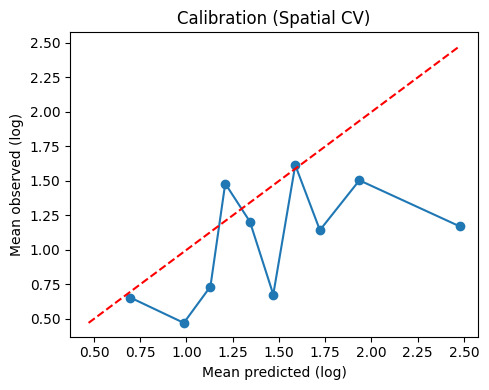

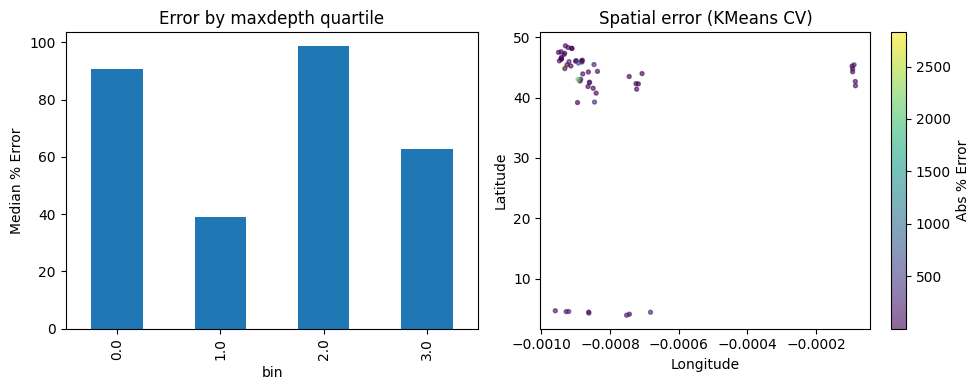

In [ ]:
sp = preds.get("km")
if sp is not None and len(sp):
    pred_log = np.log(sp["pred_secchi"].clip(1e-6,None)); obs_log = np.log(sp["obs_secchi"].clip(1e-6,None))
    q = pd.qcut(pred_log, q=10, duplicates="drop")
    cal = pd.DataFrame({"bin":q, "obs":obs_log, "pred":pred_log}).groupby("bin").agg(obs_mean=("obs","mean"), pred_mean=("pred","mean")).reset_index()

    plt.figure(figsize=(5,4))
    plt.plot(cal["pred_mean"], cal["obs_mean"], marker="o")
    lo,hi = cal[["obs_mean","pred_mean"]].values.min(), cal[["obs_mean","pred_mean"]].values.max()
    plt.plot([lo,hi],[lo,hi],'r--'); plt.xlabel("Mean predicted (log)"); plt.ylabel("Mean observed (log)")
    plt.title("Calibration (Spatial CV)"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    try:
        depth_bins = pd.qcut(pd.to_numeric(df["maxdepth"], errors="coerce"), q=4, labels=False, duplicates="drop")
        mape_depth = pd.DataFrame({"bin": depth_bins, "mape": sp["abs_pct_error"]}).dropna().groupby("bin")["mape"].median()
        mape_depth.plot(kind="bar"); plt.ylabel("Median % Error"); plt.title("Error by maxdepth quartile")
    except Exception as e:
        plt.text(0.1,0.5,f"Depth bin MAPE skipped: {e}")

    plt.subplot(1,2,2)
    sc = plt.scatter(sp["nhd_long"], sp["nhd_lat"], c=sp["abs_pct_error"], s=8, alpha=0.6)
    plt.colorbar(sc, label="Abs % Error"); plt.title("Spatial error (KMeans CV)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.tight_layout(); plt.show()


In [ ]:
def fit_quantile_pipelines(df_fit):
    if not HAS_LGBM: return None
    X_fe = engineer_features(df_fit); pre, _, _ = make_preprocessor(X_fe); _ = pre.fit(X_fe)
    q_params = dict(objective="quantile", n_estimators=1200, learning_rate=0.03, subsample=0.8,
                    colsample_bytree=0.9, reg_lambda=10.0, random_state=RANDOM_STATE, verbose=-1)
    q10 = Pipeline([("fe", FunctionTransformer(engineer_features, validate=False)), ("pre", pre),
                    ("mdl", LGBMRegressor(alpha=0.10, **q_params))])
    q90 = Pipeline([("fe", FunctionTransformer(engineer_features, validate=False)), ("pre", pre),
                    ("mdl", LGBMRegressor(alpha=0.90, **q_params))])
    y = np.log(df_fit["mean_secchi"].values); q10.fit(df_fit, y); q90.fit(df_fit, y)
    return q10, q90

def conformal_interval(base_pipe, df_fit, alpha=0.20, cal_frac=0.2):
    rng = np.random.RandomState(RANDOM_STATE)
    idx = np.arange(len(df_fit)); cal_size = max(400, int(cal_frac*len(df_fit)))
    cal_idx = rng.choice(idx, size=cal_size, replace=False); tr_idx = np.setdiff1d(idx, cal_idx)
    y_tr = np.log(df_fit.iloc[tr_idx]["mean_secchi"].values); y_cal = np.log(df_fit.iloc[cal_idx]["mean_secchi"].values)

    pipe2 = make_full_pipeline(df_fit.iloc[tr_idx]); pipe2.fit(df_fit.iloc[tr_idx], y_tr)
    cal_pred = pipe2.predict(df_fit.iloc[cal_idx]); resid = np.abs(y_cal - cal_pred); q = np.quantile(resid, 1-alpha)
    def predict_interval(new_df):
        mu = pipe2.predict(new_df)
        return np.exp(mu-q), np.exp(mu+q)
    return predict_interval

q_models = fit_quantile_pipelines(df)
conformal80 = conformal_interval(final_pipe, df, alpha=0.20, cal_frac=0.2)

lo, hi = conformal80(df)
obs = df["mean_secchi"].values
coverage = np.mean((obs >= lo) & (obs <= hi))*100
width = np.median((hi - lo)/np.maximum(obs,1e-6))*100
print(f"Split-conformal 80% PI — coverage: {coverage:.1f}% | median width: {width:.1f}% of obs")


Split-conformal 80% PI — coverage: 95.5% | median width: 341.1% of obs


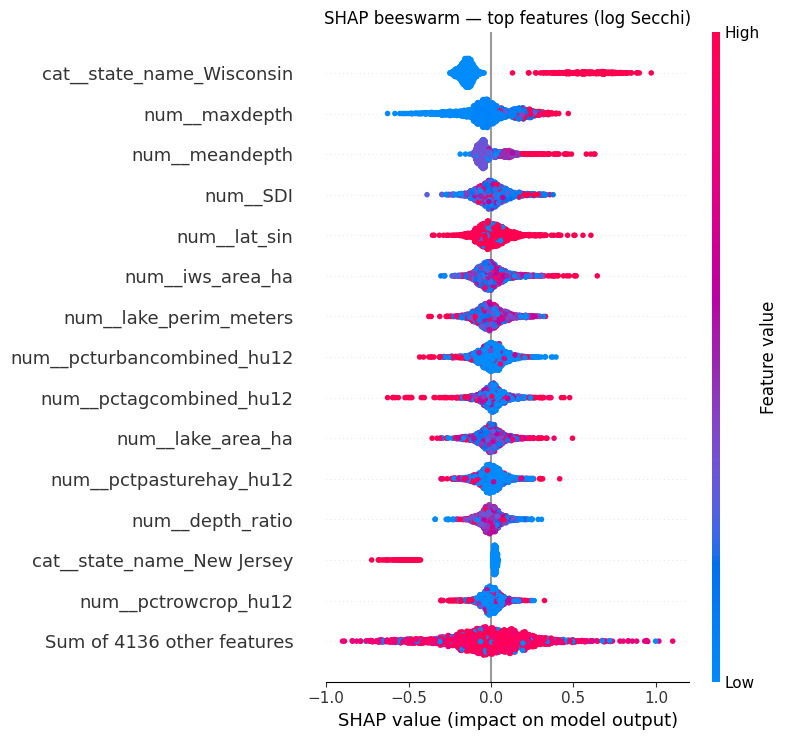

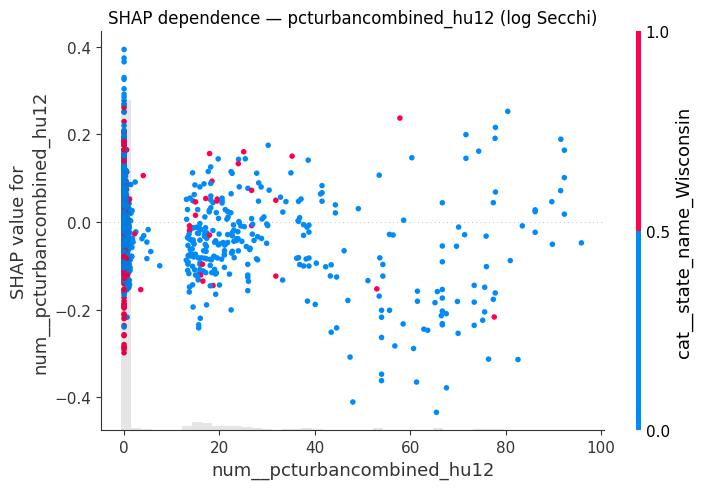

In [ ]:
import shap

fe_df  = engineer_features(df)
pre    = final_pipe.named_steps["pre"]
X_full = pre.transform(fe_df)
try:
    feat_names = list(pre.get_feature_names_out())
except Exception:
    feat_names = [f"f{i}" for i in range(X_full.shape[1])]
    print("Warning: Could not get feature names from preprocessor. Using generic names.")

rng = np.random.default_rng(42)
idx = rng.choice(X_full.shape[0], size=min(2000, X_full.shape[0]), replace=False)
X_sample = X_full[idx]

model = final_pipe.named_steps["mdl"]
explainer = shap.TreeExplainer(model, feature_names=feat_names)
shap_values = explainer(X_sample)

if not hasattr(shap_values, "feature_names"):
    shap_values.feature_names = feat_names

shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.title("SHAP beeswarm — top features (log Secchi)")
plt.tight_layout(); plt.savefig("shap_beeswarm.png", dpi=180); plt.show()

def _find(col):
    for i,n in enumerate(feat_names):
        if n.endswith(f"__{col}"): return i
    return None

col = "pcturbancombined_hu12"
i = _find(col)
if i is not None:
    if i < shap_values.shape[1]:
        shap.plots.scatter(shap_values[:, i], color=shap_values, show=False)
        plt.title(f"SHAP dependence — {col} (log Secchi)")
        plt.tight_layout(); plt.savefig("shap_dep_pcturban.png", dpi=180); plt.show()
    else:
        print(f"[SHAP] Index for column {col} ({i}) is out of bounds for SHAP values.")
else:
    print(f"[SHAP] Column {col} not found in transformed features.")

**Insight**

“SHAP menegaskan pola domain: depth_ratio mendorong prediksi ke atas (jernih), sedangkan % urban/row-crop menarik ke bawah (keruh).

“Basis spasial (sin/cos lat/lon) juga dominan—selaras dengan EDA yang menunjukkan gradient latitud.”